In [25]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *

In [77]:
def therapy_translator(x):
    if not x or str(x)=='nan':
        return 'nothing'
    x = str(x).lower()
    if 'ipi' in x or 'pembro' in x or 'pembo' in x or 'nivo' in x or 'apd' in x or 'pd1' in x:
        return 'ICI'
    
    elif 'enco' in x or 'd+t' in x:
        return 'other therapy'
    
    elif 'radiation' in x:
        return 'other therapy'
    
    elif 'carbo' in x or 'imatinib' in x or 'tmz' in x or 'tvec' in x or 'cdk4/6' in x :
        return 'other immune therapy'
    
    elif 'surgical ' in x or 'surgery ' in x or 'neodajuvant' in x:
        return 'other therapy'
       
    else:
        return x

### 1. Loads xlsx files

In [78]:
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/Melanoma_clinical_data_OCT_unportected.xlsx'
# MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'

melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)

display(clinical_labels.head(3))
display(melanoma_clinical_data.head(1))

,Clinical response,binary label,number of samples
0,NR,NR,6
1,NR (PD),NR,6
2,??,not in use for now,6


,#,Patient id,MGH id,Date collected,Sex (F/M),Age (relevant to time of sample),Melanoma type,Primary=1; Metastasis=0,Genotype,Therapy(ies) prior to biopsy,Therapy after biopsy,Clinical response,Status (Alive=1/Dead=0),Biopsy site,"Biopsy type (pre, post)",Overall survival (days),Comments,Cell line (Y; N),TILs (Y; N)
0,1,M97,1256,2019-10-11,M,79.0,Cutaneous,0,TP63; DDR2; ATM; MAP2K1; HNF1A; TERT,NaN,PD1 (started on 3/31/20),R,1.0,Left Axillary LN,Pre,NaN,NaN,NaN,NaN


##### takes only first 71 samples, fill Nan and creat dictionary mapping

In [79]:
N_SAMPLES = 71
melanoma_clinical_data = melanoma_clinical_data.iloc[:N_SAMPLES][['Patient id', 'Clinical response', 'Melanoma type', 'Therapy(ies) prior to biopsy', 'Therapy after biopsy']]
melanoma_clinical_data.head(3)

,Patient id,Clinical response,Melanoma type,Therapy(ies) prior to biopsy,Therapy after biopsy
0,M97,R,Cutaneous,NaN,PD1 (started on 3/31/20)
1,M98,R (had a response in 2016-2019),Cutaneous,"aPD1 (progressed on 7/29/19)- 18 cycles, start...",NA (surgical management)
2,M99,NR (PD),Mucosal,5/11/17- ipi+nivo; 7/18/17- nivo; 1/8/18- pemb...,TVEC


##### fill Nans

In [80]:
melanoma_clinical_data['Melanoma type'] = melanoma_clinical_data['Melanoma type'].fillna('??')
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')



### 2. Convert reponse labels, melanoma type and therapy prior/after biopsy.

##### Convert response label mapping using clinical_label table 

In [81]:
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}
labels_mapping['R '] = 'R'
labels_mapping['PD (NR; for pembro) NR for d+t'] = 'NR'
melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])

##### Convert melanoma type

In [82]:
melanoma_type_translate = {'Cutaneous': 'Cutaneous', 'Mucosal ': 'Mucosal ', 'Uveal': 'other', 'UN primary': 'other', 'Acral': 'other', 'Unknown': 'other', '??':'other'}
melanoma_clinical_data['Melanoma type'] = melanoma_clinical_data['Melanoma type'].apply(lambda rr: melanoma_type_translate[rr])


##### Convert therapy prior/after biopsy

In [83]:
melanoma_clinical_data['prior to biopsy'] = melanoma_clinical_data['Therapy(ies) prior to biopsy'].iloc[:N_SAMPLES].apply(lambda x: therapy_translator(x))
melanoma_clinical_data['after biopsy'] = melanoma_clinical_data['Therapy after biopsy'].iloc[:N_SAMPLES].apply(lambda x: therapy_translator(x))
melanoma_clinical_data['ICI'] =  (melanoma_clinical_data['prior to biopsy'] == 'ICI') | (melanoma_clinical_data['after biopsy'] == 'ICI')
melanoma_clinical_data = melanoma_clinical_data.drop(columns=['Therapy(ies) prior to biopsy', 'Therapy after biopsy', 'Clinical response'])

### 3. Visualization

In [84]:
###############################
sns.reset_orig() # reset size of figure

##### 3.1. Response

{'NR': 32, 'R': 20, 'not in use for now': 19}

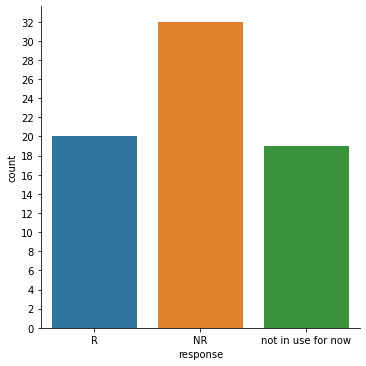

In [85]:
g = sns.catplot(data=melanoma_clinical_data, x='response', kind="count");
g.set(yticks=np.arange(0,34,2));
dict(melanoma_clinical_data['response'].value_counts())

##### 3.1.2. Resposne && ICI treatment

ICI: {'NR': 31, 'R': 18, 'not in use for now': 4}


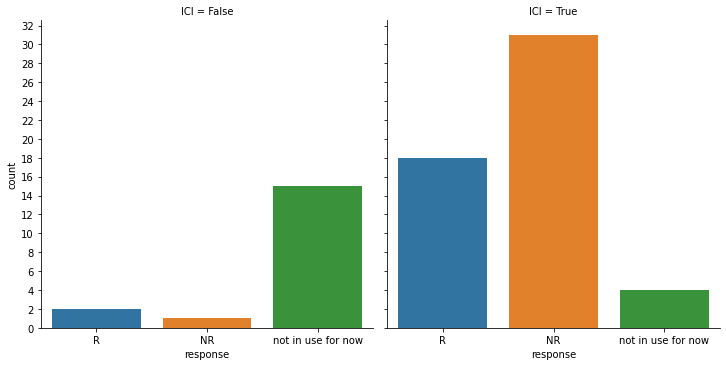

In [86]:
g = sns.catplot(data=melanoma_clinical_data, x='response', kind="count", col='ICI');
g.set(yticks=np.arange(0,34,2));
print(f'ICI:', end=' ')
print(dict(melanoma_clinical_data[melanoma_clinical_data['ICI']==True]['response'].value_counts()))

##### 3.2. Melanoma type

{'Cutaneous': 49, 'other': 14, 'Mucosal ': 8}

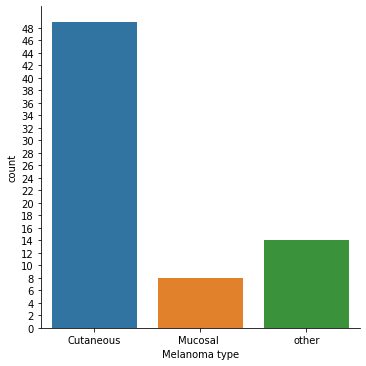

In [88]:
g = sns.catplot(data=melanoma_clinical_data, x='Melanoma type', kind="count");
g.set(yticks=np.arange(0,50,2));
dict(melanoma_clinical_data['Melanoma type'].value_counts())

##### 3.2.2. Melanoma type && ICI treatment

ICI: {'Cutaneous': 39, 'other': 7, 'Mucosal ': 7}


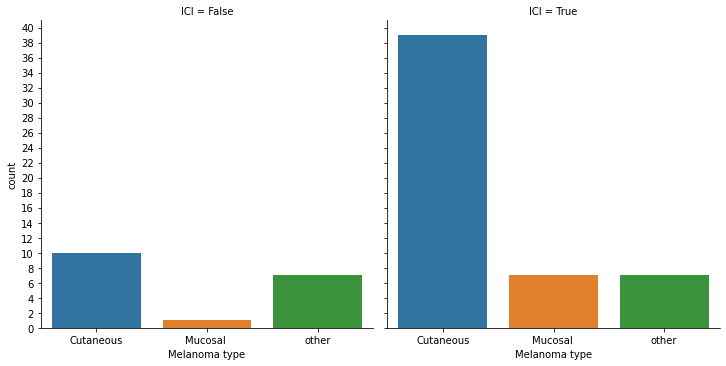

In [90]:
g = sns.catplot(data=melanoma_clinical_data, x='Melanoma type', kind="count", col='ICI');
g.set(yticks=np.arange(0,41,2));
print(f'ICI:', end=' ')
print(dict(melanoma_clinical_data[melanoma_clinical_data['ICI']==True]['Melanoma type'].value_counts()))

##### 3.3. Melanoma type && Response

count
Melanoma type response                 
Cutaneous     NR                     23
              R                      15
              not in use for now     11
Mucosal       NR                      5
              R                       2
              not in use for now      1
other         NR                      4
              R                       3
              not in use for now      7

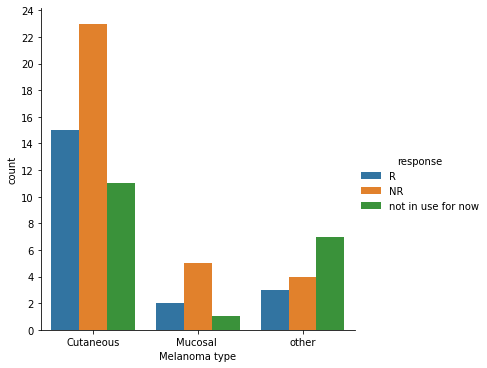

In [92]:
g = sns.catplot(data=melanoma_clinical_data, x='Melanoma type', kind="count", hue='response');
g.set(yticks=np.arange(0,25,2));
melanoma_clinical_data.drop(columns=['prior to biopsy', 'after biopsy', 'ICI']).groupby(['Melanoma type', 'response']).count().rename(columns={'Patient id':'count'})#.set_index('Melanoma type')

##### 3.3.2. Melanoma type && Response && ICI

count
ICI   Melanoma type response                 
False Cutaneous     NR                      1
                    not in use for now      9
      Mucosal       R                       1
      other         R                       1
                    not in use for now      6
True  Cutaneous     NR                     22
                    R                      15
                    not in use for now      2
      Mucosal       NR                      5
                    R                       1
                    not in use for now      1
      other         NR                      4
                    R                       2
                    not in use for now      1

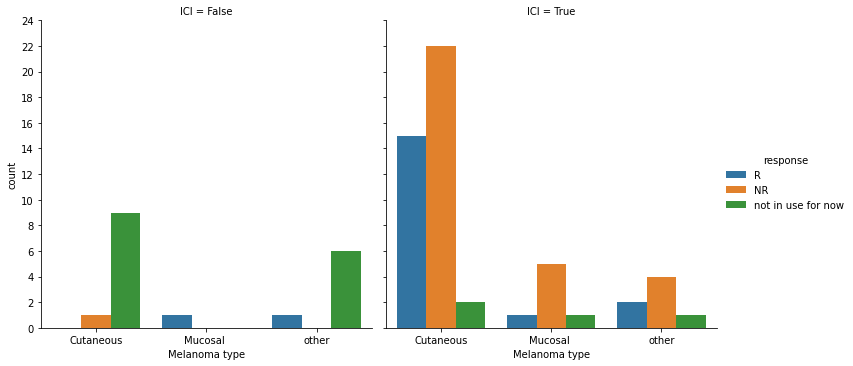

In [93]:
pd.set_option('display.max_rows', None)
g = sns.catplot(data=melanoma_clinical_data, x='Melanoma type', kind="count", hue='response', col='ICI');
g.set(yticks=np.arange(0,25,2));
# melanoma_clinical_data[melanoma_clinical_data["ICI"]==True].groupby(['Melanoma type', 'response']).count().reset_index().drop(columns=['prior to biopsy', 'after biopsy', 'ICI']).rename(columns={'Patient id':'count'}).set_index('Melanoma type')
melanoma_clinical_data.groupby(['ICI','Melanoma type', 'response']).count().drop(columns=['prior to biopsy', 'after biopsy']).rename(columns={'Patient id':'count'})

In [94]:
# melanoma_clinical_data

# DEBUG

In [74]:
melanoma_clinical_data["IPI+NIVO"] = melanoma_clinical_data["ICI"]

count
IPI+NIVO Melanoma type response                 
False    Cutaneous     NR                      9
                       R                      10
                       not in use for now     11
         Mucosal       R                       1
                       not in use for now      1
         other         NR                      3
                       R                       2
                       not in use for now      6
True     Cutaneous     NR                     14
                       R                       5
         Mucosal       NR                      5
                       R                       1
         other         NR                      1
                       R                       1
                       not in use for now      1

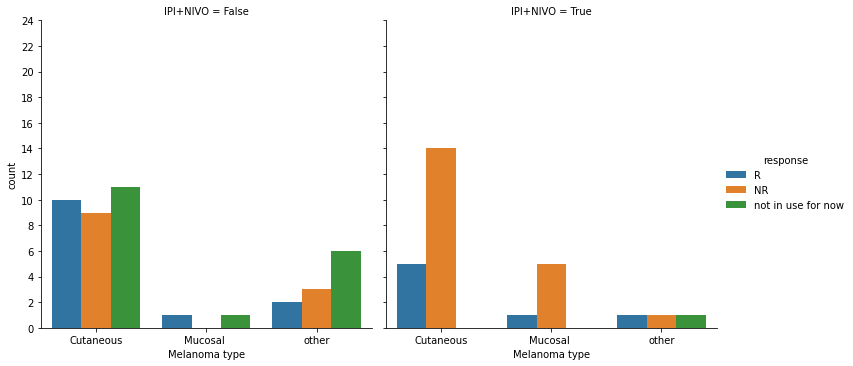

In [75]:
pd.set_option('display.max_rows', None)
g = sns.catplot(data=melanoma_clinical_data, x='Melanoma type', kind="count", hue='response', col="IPI+NIVO");
g.set(yticks=np.arange(0,25,2));
# melanoma_clinical_data[melanoma_clinical_data["ICI"]==True].groupby(['Melanoma type', 'response']).count().reset_index().drop(columns=['prior to biopsy', 'after biopsy', 'ICI']).rename(columns={'Patient id':'count'}).set_index('Melanoma type')
melanoma_clinical_data.groupby(["IPI+NIVO",'Melanoma type', 'response']).count().drop(columns=['prior to biopsy', 'after biopsy', 'ICI']).rename(columns={'Patient id':'count'})

In [83]:
print(f'ICI')
display(melanoma_clinical_data[melanoma_clinical_data['ICI']==True].groupby(['Melanoma type', 'response']).count().reset_index().drop(columns=['prior to biopsy', 'after biopsy', 'ICI']).rename(columns={'Patient id':'count'}).set_index('Melanoma type'))
print(f'NOT ICI')
display(melanoma_clinical_data[melanoma_clinical_data['ICI']==False].groupby(['Melanoma type', 'response']).count().reset_index().drop(columns=['prior to biopsy', 'after biopsy', 'ICI']).rename(columns={'Patient id':'count'}).set_index('Melanoma type'))

ICI


,response,count
Melanoma type,,
Cutaneous,NR,22
Cutaneous,R,15
Cutaneous,not in use for now,2
Mucosal,NR,5
Mucosal,R,1
Mucosal,not in use for now,1
other,NR,4
other,R,2
other,not in use for now,1


NOT ICI


,response,count
Melanoma type,,
Cutaneous,NR,1
Cutaneous,not in use for now,9
Mucosal,R,1
other,R,1
other,not in use for now,6


In [11]:
from utilities.clinical_data import *
get_clinical_data(melanoma_type=['Mucosal'])